In [7]:
import imageio 
import numpy as np
import matplotlib.pyplot as plt
import cv2
# %matplotlib widget
import sys
from scipy import sparse
sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
from skimage.measure import profile_line
import pandas as pd
from tqdm.autonotebook import tqdm


path = '20211106_A3_MT-K20_seg[5323].png'
im = imageio.imread(path)

C:\Users\coren\anaconda3\envs\cleanMsc\lib\site-packages\ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# from amftrack.pipeline.functions.image_processing.extract_width_fun import *
pixel_conversion_factor = 1/12.3
# pixel_conversion_factor = 1

def get_width_pixel(edge,index,im,pivot,before,after,size = 20,width_factor = 10,averaging_size = 100,threshold_averaging = 10):
    imtab=im
    orientation=np.array(before)-np.array(after)
    perpendicular = [1,-orientation[0]/orientation[1]] if orientation[1]!=0 else [0,1]
    perpendicular_norm=np.array(perpendicular)/np.sqrt(perpendicular[0]**2+perpendicular[1]**2)
    point1=np.around(np.array(pivot)+width_factor*perpendicular_norm)
    point2=np.around(np.array(pivot)-width_factor*perpendicular_norm)
    point1=point1.astype(int)
    point2=point2.astype(int)
    p = profile_line(imtab, point1, point2,mode='constant')
    xdata = np.array(range(len(p)))
    ydata = np.array(p)
#     print(p)
    background = 0.5
    arg = len(p)//2
    l1,l2 = [i+arg for i in range(len(p[arg:])) if p[arg+i]==255],[arg-i for i in range(len(p[:arg])) if p[arg-i]==255]
    if len(l1)==0 or len(l2)==0:
        return(-1)
    else:
        arg_max = min(l1)
        arg_min = max(l2)
        width_pix = arg_max-arg_min
        return(width_pix)

def get_width_edge(edge,graph,im,resolution,local=False, threshold_averaging = 10):
    pixel_list = graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    pixels = []
    indexes = []
    poss = []
    widths={}
    if len(pixel_list)>3*resolution:
        for i in range(0,len(pixel_list)//resolution):
            index = i*resolution
            indexes.append(index)
            pixel = pixel_list[index]
            pixels.append(pixel)
            poss.append(pixel)
    else:
        indexes = [0,len(pixel_list)//2,len(pixel_list)-1]
        for index in indexes:
            pixel = pixel_list[index]
            pixels.append(pixel)
            poss.append(pixel)
#     print(indexes)
    for i, index in enumerate(indexes[1:-1]):
        source_img = im
        pivot = poss[i+1]
        before = poss[i]
        after = poss[i+2]
        width = get_width_pixel(edge,index,source_img,pivot,before,after,threshold_averaging = threshold_averaging)
        widths[pixel_list[index]]=-1 if width==-1 else width*pixel_conversion_factor 
    return(widths)    

def get_length_um(edge,graph):
    pixels = graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    length_edge = 0
    for i in range(len(pixels) // 10 + 1):
        if i * 10 <= len(pixels) - 1:
            length_edge += np.linalg.norm(
                np.array(pixels[i * 10])
                - np.array(pixels[min((i + 1) * 10, len(pixels) - 1)])
            )
    #         length_edge+=np.linalg.norm(np.array(pixels[len(pixels)//10-1*10-1])-np.array(pixels[-1]))
    return length_edge * pixel_conversion_factor

def get_width_info(graph,im,resolution = 10):
    edge_width={}
    for edge in graph.edges:
        list_widths = list(get_width_edge(edge,graph,im,resolution).values()) 
        mean = -1 if -1 in list_widths else np.mean(list_widths)
        edge_width[edge]=mean
    return(edge_width)

def get_length_info(graph,im,resolution = 10):
    edge_length={}
    for edge in graph.edges:
        edge_length[edge]=get_length_um(edge,graph)
    return(edge_length)

In [15]:
def analyse_root_img(paths):
    begin=[]
    end = []
    begin_pos = []
    end_pos = []
    length = []
    width = []
    ids = []
    with tqdm(total=len(paths), desc="analyzing roots", leave=False) as pbar:
        for path in paths:
            path_relative = path.split("\\")[-1]
            im = imageio.imread(path)  
            gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)   
            skeletonized = cv2.ximgproc.thinning(255-gray)
            skeleton = sparse.dok_matrix(skeletonized)
            nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
            width_info = get_width_info(nx_graph,gray)
            length_info = get_length_info(nx_graph,gray)    
            canva = np.zeros((*gray.shape,4))
            for edge in width_info.keys():
                pixel_list = nx_graph.get_edge_data(edge[0], edge[1])["pixel_list"]
                for pixel in pixel_list:
                    canva[pixel[0],pixel[1],:] = np.array(plt.get_cmap('jet')(int(400*width_info[edge])))
            plt.close("all")
            plt.clf()
            fig, ax = plt.subplots()
            kernel = np.ones((5,5),np.uint8)

            ax.imshow(cv2.dilate(canva,kernel,iterations = 1))
            ax.imshow(gray,alpha = 0.2)
            plt.savefig('extracted/'+path_relative.split('.')[0]+'_overlay.png',dpi=300)
#             for edge in nx_graph.edges:
#                 begin.append(edge[0])
#                 end.append(edge[1])
#                 begin_pos.append(pos[edge[0]])
#                 end_pos.append(pos[edge[1]])    
#                 length.append(length_info[edge])
#                 width.append(width_info[edge])
#                 ids.append(path_relative)
            pbar.update(1)
#     data = pd.DataFrame(np.array((ids,begin,end,begin_pos,end_pos,length,width)).transpose(),columns=['id','begin','end','begin_pos','end_pos','length','width'])
#     data.to_csv('width_length_total.csv')    

In [16]:
from os import listdir
from os.path import isfile, join
mypath = 'Roots_Coco'
paths = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(paths))
paths = [path for path in paths if not isfile('extracted/'+path.split("\\")[-1].split('.')[0]+'_overlay.png')]
len(paths)

464


138

analyzing roots:   0%|          | 0/138 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

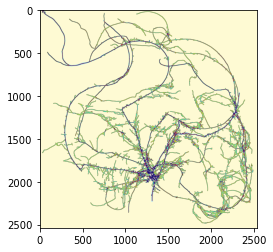

In [17]:
analyse_root_img(paths)

In [2]:
fig, ax = plt.subplots()
ax.imshow(im)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

In [4]:
255-gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
skeletonized = cv2.ximgproc.thinning(255-gray)


In [54]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
from scipy import sparse
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
skeleton = sparse.dok_matrix(skeletonized)
nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))

In [29]:
pos

{0: array([ 136, 1137]),
 3: array([ 186, 1140]),
 1: array([ 181, 1156]),
 10: array([ 204, 1162]),
 2: array([ 182, 1151]),
 4: array([ 187, 1140]),
 7: array([ 196, 1130]),
 8: array([ 198, 1145]),
 5: array([ 192, 1099]),
 6: array([ 196, 1127]),
 12: array([ 207, 1120]),
 9: array([ 200, 1421]),
 42: array([ 274, 1491]),
 13: array([ 208, 1162]),
 11: array([ 205, 1311]),
 59: array([ 299, 1264]),
 17: array([ 211, 1117]),
 14: array([ 209, 1124]),
 15: array([ 209, 1134]),
 16: array([ 210, 1165]),
 20: array([ 218, 1163]),
 18: array([ 212, 1172]),
 21: array([ 218, 1165]),
 19: array([ 213, 1114]),
 24: array([ 221, 1172]),
 22: array([ 218, 1182]),
 36: array([ 266, 1104]),
 35: array([ 265, 1113]),
 27: array([ 229, 1162]),
 23: array([ 221, 1168]),
 51: array([ 286, 1226]),
 26: array([ 228, 1172]),
 25: array([ 226, 1173]),
 30: array([ 237, 1175]),
 28: array([ 232, 1158]),
 29: array([ 234, 1162]),
 31: array([ 238, 1163]),
 33: array([ 239, 1178]),
 32: array([ 238, 1182

In [61]:
width_info = get_width_info(nx_graph,gray)

In [62]:
width_info

{(0, 3): 6.325,
 (3, 2): 5.175000000000001,
 (3, 4): 8.625,
 (1, 10): 8.625,
 (10, 7): 6.9,
 (10, 13): 8.625,
 (4, 7): 6.9,
 (4, 8): 6.9,
 (7, 6): 5.175000000000001,
 (5, 6): 6.9,
 (6, 12): 8.625,
 (12, 17): 8.625,
 (12, 14): 15.525,
 (9, 42): 7.1156250000000005,
 (42, 41): 3.45,
 (42, 44): 8.625,
 (13, 15): 5.175000000000001,
 (13, 16): 12.075000000000001,
 (11, 59): 8.409375,
 (59, 56): 6.9,
 (59, 61): 6.9,
 (17, 14): 6.9,
 (17, 19): 8.625,
 (14, 15): 5.175000000000001,
 (15, 20): 8.625,
 (16, 18): 6.9,
 (16, 21): 6.9,
 (20, 21): -1.725,
 (20, 27): 6.9,
 (18, 24): 3.45,
 (18, 22): 6.9,
 (21, 23): 8.625,
 (19, 36): 7.245,
 (19, 35): 7.4750000000000005,
 (24, 22): 6.9,
 (24, 23): 3.45,
 (22, 51): 8.625,
 (36, 35): 8.625,
 (36, 39): 8.625,
 (35, 37): 12.075000000000001,
 (23, 26): 6.9,
 (51, 33): 8.625,
 (51, 54): 10.350000000000001,
 (26, 25): 15.525,
 (26, 30): 10.350000000000001,
 (30, 29): 5.175000000000001,
 (30, 33): 10.350000000000001,
 (28, 29): 12.075000000000001,
 (29, 31): 5.

In [9]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(gray)
# for node in pos.keys():
#     ax.scatter(pos[node][1],pos[node][0])    
for edge in width_info.keys():
    ax.plot((pos[edge[0]][1],pos[edge[1]][1]),(pos[edge[0]][0],pos[edge[1]][0]),color = plt.get_cmap('jet')(int(20*width_info[edge])))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [87]:
canva = np.zeros((*gray.shape,4))
for edge in width_info.keys():
    pixel_list = nx_graph.get_edge_data(edge[0], edge[1])["pixel_list"]
    for pixel in pixel_list:
        canva[pixel[0],pixel[1],:] = np.array(plt.get_cmap('jet')(int(20*width_info[edge])))

In [86]:
plt.close("all")
fig, ax = plt.subplots()
kernel = np.ones((5,5),np.uint8)

ax.imshow(cv2.dilate(canva,kernel,iterations = 1))
ax.imshow(gray,alpha = 0.2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
canva[pixel[0],pixel[1],:]

array([0., 0., 0.])

In [15]:
plt.get_cmap('jet')(int(20*width_info[edge]))

(0.03478810879190385, 0.9431372549019608, 0.9329538266919671, 1.0)

In [ ]:
fig, ax = plt.subplots()
ax.hist(width_info.values(),25)


In [46]:
plt.get_cmap('jet')(60.5)

(0.5, 0.0, 0.0, 1.0)

In [69]:
length_info = get_length_info(nx_graph,gray)

In [70]:
length_info

{(0, 3): 89.45365006887718,
 (3, 2): 20.44904712296429,
 (3, 4): 1.725,
 (1, 10): 41.134886014267394,
 (10, 7): 57.3475143518885,
 (10, 13): 6.9,
 (4, 7): 23.222269374110997,
 (4, 8): 20.957982410848125,
 (7, 6): 5.175000000000001,
 (5, 6): 49.06633173027603,
 (6, 12): 22.781308437140638,
 (12, 17): 8.625,
 (12, 14): 7.714434522374275,
 (9, 42): 178.28071965944378,
 (42, 41): 3.45,
 (42, 44): 6.219575950175382,
 (13, 15): 48.81074985481447,
 (13, 16): 6.219575950175382,
 (11, 59): 184.07021573321637,
 (59, 56): 24.362357204190467,
 (59, 61): 14.22471440838093,
 (17, 14): 12.558189559008895,
 (17, 19): 6.219575950175382,
 (14, 15): 17.25,
 (15, 20): 52.904133739145855,
 (16, 18): 12.558189559008895,
 (16, 21): 13.8,
 (20, 21): 3.45,
 (20, 27): 19.061035446433536,
 (18, 24): 15.525,
 (18, 22): 20.84649696928542,
 (21, 23): 7.318555185280767,
 (19, 36): 119.02144323178389,
 (19, 35): 90.30922757804922,
 (24, 22): 18.089786891371364,
 (24, 23): 6.9,
 (22, 51): 141.5147826873959,
 (36, 35):

In [72]:
begin=[]
end = []
begin_pos = []
end_pos = []
length = []
width = []
for edge in nx_graph.edges:
    begin.append(edge[0])
    end.append(edge[1])
    begin_pos.append(pos[edge[0]])
    end_pos.append(pos[edge[1]])    
    length.append(length_info[edge])
    width.append(width_info[edge])

In [75]:
data = pd.DataFrame(np.array((begin,end,begin_pos,end_pos,length,width)).transpose(),columns=['begin','end','begin_pos','end_pos','length','width'])

C:\Users\coren\anaconda3\envs\cleanMsc\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [78]:
data.to_csv(path.split('.')[0]+'.csv')